In [1]:
import RtKernel as ker
import RtDlr as dlr
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    "font.size" : 8
})

Set Parameters

In [2]:
#betas = [0,10,20,40,80]
#N_maxs = np.arange(5,21,5)
betas = [10,20]
N_maxs = [50,100]
delta_t = 0.1
cutoff = 600
phi = np.pi/4
#set the values of m that should be explored
nbr_discrete_points = list(map(int, [np.exp(0.135 * i) for i in range(15, 39,1)]))

Compute 

In [3]:
D = np.empty((len(betas), len(N_maxs), len(nbr_discrete_points)), dtype=object) 
abs_time_integrated_error = np.empty((len(betas), len(N_maxs), len(nbr_discrete_points)))

#compute continuous integral results
times = ker.set_time_grid(N_max = N_maxs[-1], delta_t = delta_t)#time grid up to maximal time used
cont_integral = np.array([ker.cont_integral(t, beta, cutoff) for beta in betas for t in times]).reshape(len(betas), len(times))#array containing all values for the continuous integration result

for b, beta in enumerate(betas):
    for tau, N_max in enumerate(N_maxs):
        #compute array containing absolute time integrated error for each m
        abs_time_integrated_error[b,tau] = [ker.DiscrError(m,m,N_max,delta_t,beta,cutoff).error_time_integrated(time_series_exact=cont_integral[b,:N_max]) for m in nbr_discrete_points]
        #compute ID and SVD
        D[b,tau] =  [dlr.RtDlr(N_max, delta_t, beta, cutoff, m, m, eps = abs_time_integrated_error[b,tau,i]) for i,m in enumerate(nbr_discrete_points)]

Set up plots

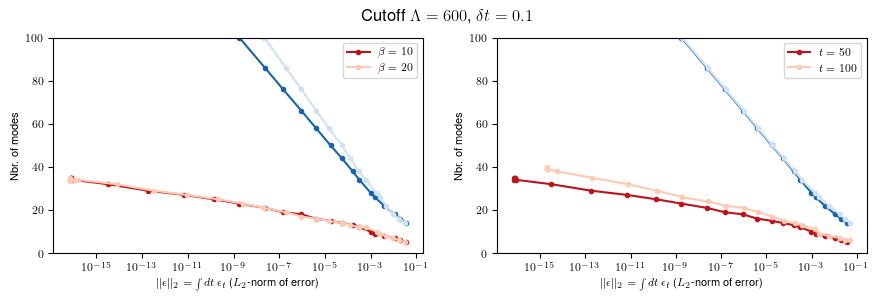

In [5]:
# Create a color gradient based on the index I
cmaps = [plt.colormaps['Blues'], plt.colormaps['Reds']]
colors_blue = cmaps[0](np.linspace(.8,0.2, len(betas)))
colors_orange = cmaps[1](np.linspace(.8,0.2, len(betas)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5,2.8))  # 1 row, 2 column
fig.suptitle('Cutoff 'r'$\Lambda = {}$'.format(cutoff)+ ',   '+ r'$\delta t={}$'.format(delta_t), fontsize = 12)

#Fixed t:
tau = 0
for b in np.arange(len(betas)):
    errors = abs_time_integrated_error[b,tau,:]
    nbr_ID_modes = np.array([D[b, tau,k].ID_rank for k in range (len(nbr_discrete_points))])
    nbr_bare_modes = np.array([D[b, tau,k].m for k in range (len(nbr_discrete_points))])
    ax1.plot(errors, nbr_ID_modes, color = colors_orange[b], label = r'$\beta = {}$'.format(betas[b]), marker = '.')
    ax1.plot(errors, 2 * nbr_bare_modes, color = colors_blue[b], marker = '.')

#Fixed beta:
b = 0
for tau in np.arange(len(N_maxs)):
    errors = abs_time_integrated_error[b,tau,:]
    nbr_ID_modes = np.array([D[b, tau,k].ID_rank for k in range (len(nbr_discrete_points))])
    nbr_bare_modes = np.array([D[b, tau,k].m for k in range (len(nbr_discrete_points))])
    ax2.plot(errors, nbr_ID_modes, color = colors_orange[tau], label = r'$t = {}$'.format(N_maxs[tau]), marker = '.')
    ax2.plot(errors, 2 * nbr_bare_modes, color = colors_blue[tau], marker = '.')
        
ax1.set_ylabel('Nbr. of modes')
ax1.set_xlabel(r'$||\epsilon||_2 = \int dt\, \epsilon_t$' + '  (' + r'$L_2$-' + 'norm of error)')
ax1.set_xscale('log')
ax1.set_ylim([0,100])
#ax1.text(1.e-13,50,r'$t={}$'.format(N_maxs[0]) + '\n blue: Nbr. pseudomodes \n red: ID-rank \n lighter = larger beta')
ax1.legend()

ax2.set_ylabel('Nbr. of modes')
ax2.set_xlabel(r'$||\epsilon||_2 = \int dt\, \epsilon_t$' + '  (' + r'$L_2$-' + 'norm of error)')
ax2.set_xscale('log')
ax2.set_ylim([0,100])
#ax2.text(1.e-13,50,r'$\beta={}$'.format(betas[0]) + '\n blue: Nbr. pseudomodes \n red: ID-rank \n lighter = larger tmax')
ax2.legend()
